In [1]:
# The Objective of this Excercise is to label the photos using Keras Functions. Here we have used Mimic3 data from Kaggle. Different Functions used are LSTM, GRU ConvID.
## 1.0 Call libraries
# 1.1 Data wrangling
%reset -f
import pandas as pd
import numpy as np

#1.2 Keras libraries
from keras.layers import Input, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten,Embedding, GRU,LSTM
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# 1.3 For plotting model
from keras.utils import  plot_model

# 1.4 sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# 1.4 For model plotting
import matplotlib.pyplot as plt
import pydot
from skimage import io

# 1.5 Misc
import os
import time


/home/ashok/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# To Stablise the Data Set of Test and Train
np.random.seed(45)

In [3]:
################ BB. Read/Process data ##################
## 2.0 Read Data
# 2.1
pathToData = "/home/ashok/.keras/datasets/mimic3"
os.chdir(pathToData)

In [4]:
# 2.2
data = pd.read_csv("mimic3d.zip",
	               compression='infer',
                   encoding='utf-8'      # 'utf-8' gives error, hence the choice
                  )

In [5]:
# 2.3 Inspect the data
data.shape            # (58976, 28)
data.head(3)
data.tail(3)
data.dtypes           # mix of int64, float64 and object
data.columns.values   # Our target column is LOSdays

(58976, 28)

,hadm_id,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,...,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum
0,100001,F,35,6.17,EMERGENCY,CLINIC REFERRAL/PREMATURE,DIABETIC KETOACIDOSIS,Private,PROTESTANT QUAKER,DIVORCED,...,0.65,0.05,5.19,14.91,1.13,0.65,398.70,0,493.89,1
1,100003,M,59,4.04,EMERGENCY,EMERGENCY ROOM ADMIT,UPPER GI BLEED,Private,NOT SPECIFIED,SINGLE,...,1.24,1.59,5.45,7.18,0.99,1.24,373.02,0,465.71,1
2,100006,F,48,12.04,EMERGENCY,EMERGENCY ROOM ADMIT,COPD FLARE,Private,NOT SPECIFIED,SINGLE,...,0.33,0.15,4.15,6.23,0.00,0.33,286.21,0,344.00,3


,hadm_id,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,...,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum
58973,199995,M,23,16.75,EMERGENCY,PHYS REFERRAL/NORMAL DELI,ROOT ABSCESS,Private,PROTESTANT QUAKER,SINGLE,...,0.54,0.10,6.27,5.79,0.00,0.36,207.10,0,261.30,3
58974,199998,M,69,5.88,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Medicare,CATHOLIC,MARRIED,...,0.17,0.35,12.24,17.69,0.00,1.02,426.87,0,537.42,1
58975,199999,M,88,5.50,EMERGENCY,CLINIC REFERRAL/PREMATURE,PNEUMONIA,Medicare,JEWISH,MARRIED,...,1.64,0.40,4.73,5.82,0.55,0.73,550.36,0,614.59,1


hadm_id               int64
gender               object
age                   int64
LOSdays             float64
admit_type           object
admit_location       object
AdmitDiagnosis       object
insurance            object
religion             object
marital_status       object
ethnicity            object
NumCallouts         float64
NumDiagnosis        float64
NumProcs            float64
AdmitProcedure       object
NumCPTevents        float64
NumInput            float64
NumLabs             float64
NumMicroLabs        float64
NumNotes            float64
NumOutput           float64
NumRx               float64
NumProcEvents       float64
NumTransfers        float64
NumChartEvents      float64
ExpiredHospital       int64
TotalNumInteract    float64
LOSgroupNum           int64
dtype: object

array(['hadm_id', 'gender', 'age', 'LOSdays', 'admit_type',
       'admit_location', 'AdmitDiagnosis', 'insurance', 'religion',
       'marital_status', 'ethnicity', 'NumCallouts', 'NumDiagnosis',
       'NumProcs', 'AdmitProcedure', 'NumCPTevents', 'NumInput',
       'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx',
       'NumProcEvents', 'NumTransfers', 'NumChartEvents',
       'ExpiredHospital', 'TotalNumInteract', 'LOSgroupNum'], dtype=object)

In [6]:
"""
List of columns
===============
    # array(['hadm_id', 'gender', 'age', 'LOSdays', 'admit_type',
       'admit_location', 'AdmitDiagnosis', 'insurance', 'religion',
       'marital_status', 'ethnicity', 'NumCallouts', 'NumDiagnosis',
       'NumProcs', 'AdmitProcedure', 'NumCPTevents', 'NumInput',
       'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx',
       'NumProcEvents', 'NumTransfers', 'NumChartEvents',
       'ExpiredHospital', 'TotalNumInteract', 'LOSgroupNum'], dtype=object)

Target column - LOSdays
"""

# 2.4 Drop first column: 'hadm_id', being id column
data.drop(['hadm_id'], axis = 'columns' , inplace = True)


# 2.5 Any missing value?
data.isnull().values.sum()        # 10611

"\nList of columns\n===============\n    # array(['hadm_id', 'gender', 'age', 'LOSdays', 'admit_type',\n       'admit_location', 'AdmitDiagnosis', 'insurance', 'religion',\n       'marital_status', 'ethnicity', 'NumCallouts', 'NumDiagnosis',\n       'NumProcs', 'AdmitProcedure', 'NumCPTevents', 'NumInput',\n       'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx',\n       'NumProcEvents', 'NumTransfers', 'NumChartEvents',\n       'ExpiredHospital', 'TotalNumInteract', 'LOSgroupNum'], dtype=object)\n\nTarget column - LOSdays\n"

10611

In [7]:
# 2.6 Which columns?
data.columns[data.isnull().sum()  > 0]    # Three: Index(['AdmitDiagnosis', 'religion', 'marital_status'], dtype='object')

# 2.7 Let us follow a conservative and safe approach to fill missing values
data.AdmitDiagnosis = data.AdmitDiagnosis.fillna("missing")
data.religion = data.religion.fillna("missing")
data.marital_status = data.marital_status.fillna("missing")
data.isnull().values.sum()        # 0

Index(['AdmitDiagnosis', 'religion', 'marital_status'], dtype='object')

0

In [8]:
# 3 Divide data into train/test
dtrain,  dtest = train_test_split(data, test_size=0.33)

In [9]:
# 4. Which columns are 'object'
obj_columns = data.select_dtypes(include = ['object']).columns.values
obj_columns

# 4.1 Which columns have numeric data
num = data.select_dtypes(include = ['int64', 'float64']).columns.values
num

"""
array(['age', 'LOSdays', 'NumCallouts', 'NumDiagnosis', 'NumProcs',
       'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes',
       'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers',
       'NumChartEvents', 'ExpiredHospital', 'TotalNumInteract',
       'LOSgroupNum'], dtype=object)

IInd column is target
And columns 'ExpiredHospital', 'LOSgroupNum' are categorical. See below

"""

# Levels in columns: 'ExpiredHospital', 'LOSgroupNum'
data.LOSgroupNum.value_counts()          # 4 levels
data.ExpiredHospital.value_counts()      # 2 levels


# 4.2 Among object, columns, let us check levels of each
#     column

for i in obj_columns:
	print(i,len(data[i].value_counts()))

"""
Our observation on above:

	Columns: a) gender, admit_type, admit_location, insurance, marital_status have levels < 10
	         b) religion and ethnicity have levels < 100
	         c) AdmitDiagnosis and AdmitProcedure have levels >100

	We accordingly:
		OneHotEnocde: (a) + also 'ExpiredHospital', 'LOSgroupNum'
		LabelEncode   (b)
	And
		Tokenize      (c)
"""

# 4.3 Final list of numerical columns. Exclude LOSdays being target
#      and also 'ExpiredHospital', 'LOSgroupNum'

num = ['age', 'NumCallouts', 'NumDiagnosis', 'NumProcs',
       'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes',
       'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers',
       'NumChartEvents', 'TotalNumInteract']

array(['gender', 'admit_type', 'admit_location', 'AdmitDiagnosis',
       'insurance', 'religion', 'marital_status', 'ethnicity',
       'AdmitProcedure'], dtype=object)

array(['age', 'LOSdays', 'NumCallouts', 'NumDiagnosis', 'NumProcs',
       'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes',
       'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers',
       'NumChartEvents', 'ExpiredHospital', 'TotalNumInteract',
       'LOSgroupNum'], dtype=object)

"\narray(['age', 'LOSdays', 'NumCallouts', 'NumDiagnosis', 'NumProcs',\n       'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes',\n       'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers',\n       'NumChartEvents', 'ExpiredHospital', 'TotalNumInteract',\n       'LOSgroupNum'], dtype=object)\n\nIInd column is target\nAnd columns 'ExpiredHospital', 'LOSgroupNum' are categorical. See below\n\n"

1    18755
0    16618
3    14261
2     9342
Name: LOSgroupNum, dtype: int64

0    53122
1     5854
Name: ExpiredHospital, dtype: int64

gender 2
admit_type 4
admit_location 9
AdmitDiagnosis 15692
insurance 5
religion 21
marital_status 8
ethnicity 41
AdmitProcedure 1277


"\nOur observation on above:\n\n\tColumns: a) gender, admit_type, admit_location, insurance, marital_status have levels < 10\n\t         b) religion and ethnicity have levels < 100\n\t         c) AdmitDiagnosis and AdmitProcedure have levels >100\n\n\tWe accordingly:\n\t\tOneHotEnocde: (a) + also 'ExpiredHospital', 'LOSgroupNum'\n\t\tLabelEncode   (b)\n\tAnd\n\t\tTokenize      (c)\n"

In [10]:
# 4.4 Final seven obj_columns for One Hot Encoding
obj_cols = ["gender", "admit_type", "admit_location", "insurance" ,"marital_status", 'ExpiredHospital', 'LOSgroupNum']
ohe = OneHotEncoder()

In [11]:
# 4.4.1 Traing on dtrain
ohe = ohe.fit(dtrain[obj_cols])

In [12]:
# 4.4.2 Transform train (dtrain) and test (dtest) data
dtrain_ohe = ohe.fit_transform(dtrain[obj_cols])
dtest_ohe = ohe.transform(dtest[obj_cols])
# 4.4.3
dtrain_ohe.shape       # (39513, 34)
dtest_ohe.shape        # (19463, 34)

(39513, 34)

(19463, 34)

In [13]:
# 5.0 Label encode relegion and ethnicity
# 5.1 First 'religion'
le = LabelEncoder()
le.fit(dtrain["religion"])
dtrain["re"] = le.transform(dtrain['religion'])    # Create new column in dtrain
dtest["re"] = le.transform(dtest['religion'])      #   and in dtest

# 5.2 Now 'ethnicity'
le = LabelEncoder()
le.fit(dtrain["ethnicity"])
dtrain["eth"]= le.transform(dtrain['ethnicity'])   # Create new column in dtrain
dtest["eth"]= le.transform(dtest['ethnicity'])     #   and in dtest

LabelEncoder()

/home/ashok/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/ashok/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


LabelEncoder()

/home/ashok/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/ashok/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [14]:

# 6. Finally transform two obj_columns for tokenization
te_ad = Tokenizer()
# 6.1 Train tokenizer on train data ie 'dtrain'
te_ad.fit_on_texts(data.AdmitDiagnosis.values)
# 6.2 Transform both dtrain and dtest and create new columns
dtrain["ad"] = te_ad.texts_to_sequences(dtrain.AdmitDiagnosis)
dtest["ad"] = te_ad.texts_to_sequences(dtest.AdmitDiagnosis)

dtrain.head(3)
dtest.head(3)

# 6.3 Similarly for column: AdmitProcedure
te_ap = Tokenizer(oov_token='<unk>')
te_ap.fit_on_texts(data.AdmitProcedure.values)
dtrain["ap"] = te_ap.texts_to_sequences(dtrain.AdmitProcedure)
dtest["ap"] = te_ap.texts_to_sequences(dtest.AdmitProcedure)

dtrain.head(3)
dtest.head(3)

/home/ashok/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/ashok/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,ethnicity,...,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum,re,eth,ad
44011,F,66,18.67,ELECTIVE,PHYS REFERRAL/NORMAL DELI,MITRAL INSUFFICIENCY\SEPTAL MYOMECTOMY ? MITRA...,Private,JEWISH,MARRIED,WHITE,...,4.71,0.75,0.21,100.48,0,130.61,3,10,36,"[33, 163, 173, 800, 33, 18, 25, 2]"
20769,M,73,7.13,EMERGENCY,CLINIC REFERRAL/PREMATURE,PNEUMONIA,Medicaid,NOT SPECIFIED,MARRIED,ASIAN,...,9.26,2.10,0.42,554.84,0,631.52,1,14,2,[10]
53860,M,82,8.04,EMERGENCY,EMERGENCY ROOM ADMIT,PNEUMONIA,Medicare,CATHOLIC,MARRIED,WHITE,...,8.83,0.00,0.62,413.18,1,490.80,2,3,36,[10]


,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,ethnicity,...,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum,re,eth,ad
36330,F,78,13.92,EMERGENCY,EMERGENCY ROOM ADMIT,NEW BRAIN MASS,Medicare,PROTESTANT QUAKER,WIDOWED,WHITE,...,7.04,0.65,0.36,110.34,0,154.77,3,16,36,"[290, 65, 50]"
36075,F,72,8.83,EMERGENCY,EMERGENCY ROOM ADMIT,CHEST PAIN;SHORTNESS OF BREATH,Medicare,NOT SPECIFIED,MARRIED,WHITE,...,0.00,0.00,0.34,493.66,0,638.90,2,14,36,"[20, 9, 86, 54, 84]"
24994,M,81,7.92,URGENT,TRANSFER FROM HOSP/EXTRAM,SUBDURAL HEMATOMA,Medicare,OTHER,UNKNOWN (DEFAULT),UNKNOWN/NOT SPECIFIED,...,0.00,0.00,0.51,173.36,0,220.48,1,15,35,"[48, 45]"


/home/ashok/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ashok/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,ethnicity,...,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum,re,eth,ad,ap
44011,F,66,18.67,ELECTIVE,PHYS REFERRAL/NORMAL DELI,MITRAL INSUFFICIENCY\SEPTAL MYOMECTOMY ? MITRA...,Private,JEWISH,MARRIED,WHITE,...,0.75,0.21,100.48,0,130.61,3,10,36,"[33, 163, 173, 800, 33, 18, 25, 2]","[13, 11, 16, 78, 59]"
20769,M,73,7.13,EMERGENCY,CLINIC REFERRAL/PREMATURE,PNEUMONIA,Medicaid,NOT SPECIFIED,MARRIED,ASIAN,...,2.10,0.42,554.84,0,631.52,1,14,2,[10],"[4, 5, 6, 3, 7, 8]"
53860,M,82,8.04,EMERGENCY,EMERGENCY ROOM ADMIT,PNEUMONIA,Medicare,CATHOLIC,MARRIED,WHITE,...,0.00,0.62,413.18,1,490.80,2,3,36,[10],"[20, 12, 1]"


,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,ethnicity,...,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum,re,eth,ad,ap
36330,F,78,13.92,EMERGENCY,EMERGENCY ROOM ADMIT,NEW BRAIN MASS,Medicare,PROTESTANT QUAKER,WIDOWED,WHITE,...,0.65,0.36,110.34,0,154.77,3,16,36,"[290, 65, 50]","[232, 233, 234, 37]"
36075,F,72,8.83,EMERGENCY,EMERGENCY ROOM ADMIT,CHEST PAIN;SHORTNESS OF BREATH,Medicare,NOT SPECIFIED,MARRIED,WHITE,...,0.00,0.34,493.66,0,638.90,2,14,36,"[20, 9, 86, 54, 84]","[4, 5, 6, 3, 7, 8]"
24994,M,81,7.92,URGENT,TRANSFER FROM HOSP/EXTRAM,SUBDURAL HEMATOMA,Medicare,OTHER,UNKNOWN (DEFAULT),UNKNOWN/NOT SPECIFIED,...,0.00,0.51,173.36,0,220.48,1,15,35,"[48, 45]",[2]


In [15]:
# 7. Standardize numerical data
se = StandardScaler()
# 7.1 Train om dtrain
se.fit(dtrain.loc[:,num])
# 7.2 Then transform both dtrain and dtest
dtrain[num] = se.transform(dtrain[num])
dtest[num] = se.transform(dtest[num])
dtest.loc[:,num].head(3)

StandardScaler(copy=True, with_mean=True, with_std=True)

/home/ashok/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ashok/anaconda3/envs/tensorflow/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/ashok/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

,age,NumCallouts,NumDiagnosis,NumProcs,NumCPTevents,NumInput,NumLabs,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,TotalNumInteract
36330,0.962845,-0.179826,-0.233210,-0.191466,-0.417580,-0.352450,-0.273118,-0.002060,-0.060538,-0.725006,-0.205158,-0.021573,-0.227448,-0.650235,-0.605810
36075,0.731577,-0.604883,-0.191179,-0.091572,-0.524527,0.634769,0.183277,0.218813,-0.058535,0.072248,-0.765520,-0.331121,-0.233568,-0.055888,0.001314
24994,1.078479,-0.604883,-0.177548,-0.209867,-0.524527,-0.426861,-0.082445,-0.018889,-0.059775,-0.776399,-0.765520,-0.331121,-0.181553,-0.552521,-0.523406


In [16]:
# 8. Get max length of the sequences
#    in dtrain["ad"], dtest["ad"]
maxlen_ad = 0
for i in dtrain["ad"]:
	if maxlen_ad < len(i):
		maxlen_ad = len(i)

for i in dtest["ad"]:
	if maxlen_ad < len(i):
		maxlen_ad = len(i)

maxlen_ad     # 24

24

In [17]:
# 8.1 Get max length of the sequences
#    in dtrain["ap"], dtest["ap"]

maxlen_ap = 0
for i in dtrain["ap"]:
	if maxlen_ap < len(i):
		maxlen_ap = len(i)

maxlen_ap      # 7

for i in dtest["ap"]:
	if maxlen_ap < len(i):
		maxlen_ap = len(i)

maxlen_ap     # 7

7

7

In [18]:
# 9. Get max vocabulary size ie value of highest
#    integer in dtrain["ad"] and in dtest["ad"]

one = np.max([np.max(i) for i in dtrain["ad"].tolist() ])
two = np.max([np.max(i) for i in dtest["ad"].tolist() ])
MAX_VOCAB_AD = np.max([one,two])

# 9.1 Get max vocabulary size ie value of highest
#     integer in dtrain["ap"] and in dtest["ap"]

one = np.max([np.max(i) for i in dtrain["ap"].tolist() ])
two = np.max([np.max(i) for i in dtest["ap"].tolist() ])
MAX_VOCAB_AP = np.max([one,two])

# 9.2
MAX_VOCAB_RE = len(dtrain.religion.value_counts())
MAX_VOCAB_ETH = len(dtrain.ethnicity.value_counts())

In [19]:
# 10. Let us put our data in a dictionary form
#     Required when we have multiple inputs
#     to Deep Neural network. Each Input layer
#     should also have the corresponding 'key'
#     name

# 10.1 Training data
Xtr = {
	"num" : dtrain[num].values,          # Note the name 'num'
	"ohe" : dtrain_ohe.toarray(),        # Note the name 'ohe'
	"re"  : dtrain["re"].values,
	"eth" : dtrain["eth"].values,
	"ad"  : pad_sequences(dtrain.ad, maxlen=maxlen_ad),
	"ap"  : pad_sequences(dtrain.ap, maxlen=maxlen_ap )
      }

# 10.2 Test data
Xte = {
	"num" : dtest[num].values,
	"ohe" : dtest_ohe.toarray(),
	"re"  : dtest["re"].values,
	"eth" : dtest["eth"].values,
	"ad"  : pad_sequences(dtest.ad, maxlen=maxlen_ad ),
	"ap"  : pad_sequences(dtest.ap, maxlen=maxlen_ap )
      }

# 10.3 Just check shapes
Xtr["num"].shape         # (39513, 15)
Xtr["ohe"].shape         # (39513, 34)
Xtr["ad"].shape          # (39513, 24)
Xtr["ap"].shape          # (39513, 7)
Xtr["re"].shape          # (39513,)  1D
Xtr["eth"].shape         # (39513,)  1D

(39513, 15)

(39513, 34)

(39513, 24)

(39513, 7)

(39513,)

(39513,)

In [20]:
# 11. Design a simple model now

dr_level = 0.1

# 11.1
num = Input(
                      shape= (Xtr["num"].shape[1], ),
					  name = "num"            # Name 'num' should be a key in the dictionary for numpy array input
					                          #    That is, this name should be the same as that of key in the dictionary
					  )

# 11.2
ohe =   Input(
                      shape= (Xtr["ohe"].shape[1], ),
					  name = "ohe"
					  )

# 11.3
re =   Input(
                      shape= [1],  # 1D shape or one feature
					  name = "re"
					  )
# 11.4
eth =   Input(
                      shape= [1],  # 1D shape or one feature
					  name = "eth"
					  )
# 11.5
ad =   Input(
                      shape= (Xtr["ad"].shape[1], ),
					  name = "ad"
					  )
# 11.6
ap =   Input(
                      shape= (Xtr["ap"].shape[1],),
					  name = "ap"
					  )

In [21]:
# 12. Embedding layers for each of the two of the columns with sequence data
#     Why add 1 to vocabulary?
#     See: https://stackoverflow.com/questions/52968865/invalidargumenterror-indices127-7-43-is-not-in-0-43-in-keras-r

emb_ad  =      Embedding(MAX_VOCAB_AD+ 1 ,      32  )(ad )
emb_ap  =      Embedding(MAX_VOCAB_AP+ 1 ,      32  )(ap)
# 12.1 Embedding layers for the two categorical variables
emb_re  =      Embedding(MAX_VOCAB_RE+ 1 ,      32  )(re)
emb_eth =      Embedding(MAX_VOCAB_ETH+ 1 ,      32  )(eth)

# 12.2 RNN layers for sequences
rnn_ad = GRU(16) (emb_ad)          # Output of GRU is a vector of size 8
rnn_ap = GRU(16) (emb_ap)

### Addition of Layers within Input Layers

In [22]:
# a layer instance is callable on a tensor, and returns a tensor
emb_ohe  =      Embedding(Xtr["ohe"].shape[1], 32 )(ohe)
emb_ohe.shape

TensorShape([Dimension(None), Dimension(34), Dimension(32)])

In [23]:
ohe_ls=LSTM(32)(emb_ohe)
ohe_ls.shape

TensorShape([Dimension(None), Dimension(32)])

In [24]:
# 12.3 Modified model summary.
#      For 'output' we have all the existing (unterminated) outputs
model = Model([num, ohe, re, eth, ad,ap], [rnn_ad, rnn_ap, emb_re, emb_eth, num, ohe_ls])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ad (InputLayer)                 (None, 24)           0                                            
__________________________________________________________________________________________________
ap (InputLayer)                 (None, 7)            0                                            
__________________________________________________________________________________________________
ohe (InputLayer)                (None, 34)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 24, 32)       157920      ad[0][0]                         
__________________________________________________________________________________________________
embedding_

### Resuming  The Normal Modelling as per excercise document

In [25]:
# 12.4 Concatenate all outputs
class_l = concatenate([
                      rnn_ad,        # GRU output is already 1D
                      rnn_ap,
                      num,           # 1D output. No need to flatten. See model summary
					  ohe_ls,           # 1D output
					  Flatten()(emb_re),   # Why flatten? See model summary above
					  Flatten()(emb_eth)
                      ]
                     )

# 12.5 Add classification layer
class_l = Dense(64) (class_l)
class_l = Dropout(0.1)(class_l)
class_l = Dense(32) (class_l)
class_l = Dropout(0.1) (class_l)

# 12.6 Output neuron. Activation is linear
#      as our output is continous
output = Dense(1, activation="linear") (class_l)

# 12.7 Formulate Model now
model = Model(
              inputs= [num, ohe, re, eth, ad, ap],
              outputs= output
             )

# 12.8
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ad (InputLayer)                 (None, 24)           0                                            
__________________________________________________________________________________________________
ap (InputLayer)                 (None, 7)            0                                            
__________________________________________________________________________________________________
ohe (InputLayer)                (None, 34)           0                                            
__________________________________________________________________________________________________
re (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
eth (Input

/home/ashok/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


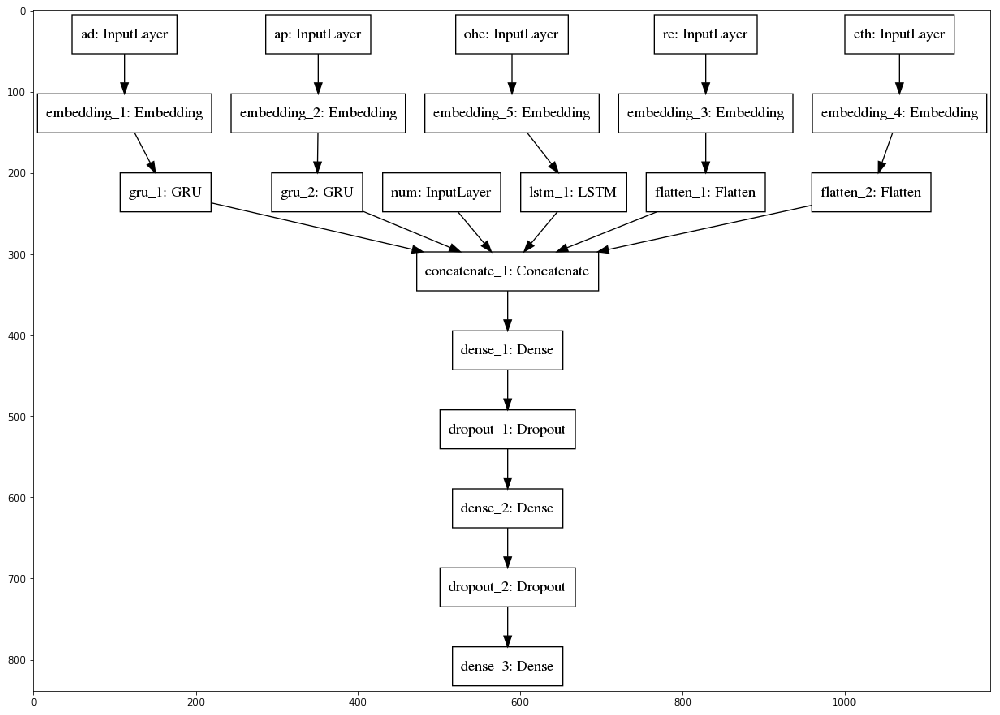

In [26]:
# 12.9 Model plot uisng keras plot_model()
plt.figure(figsize = (14,14))
plot_model(model, to_file = "model.png")
io.imshow("model.png")

In [27]:
# 13. Compile model
model.compile(loss="mse",
              optimizer="adam",
              metrics=["mae"]
			  )

# 13.1
BATCH_SIZE = 5000
epochs = 50

# 13.2
start = time.time()
history= model.fit(Xtr,
                   dtrain.LOSdays,
                   epochs=epochs,
                   batch_size=BATCH_SIZE,
				   validation_data=(Xte, dtest.LOSdays),
				   verbose = 1
                  )
end = time.time()
print((end-start)/60)

Train on 39513 samples, validate on 19463 samples
Epoch 1/50
39513/39513 [==============================] - 18s 445us/step - loss: 246.4639 - mean_absolute_error: 9.8137 - val_loss: 249.4741 - val_mean_absolute_error: 9.4277
Epoch 2/50
39513/39513 [==============================] - 15s 378us/step - loss: 221.9238 - mean_absolute_error: 8.7665 - val_loss: 214.4743 - val_mean_absolute_error: 7.8586
Epoch 3/50
39513/39513 [==============================] - 16s 408us/step - loss: 174.0765 - mean_absolute_error: 6.8004 - val_loss: 153.7493 - val_mean_absolute_error: 6.7256
Epoch 4/50
39513/39513 [==============================] - 16s 407us/step - loss: 146.4326 - mean_absolute_error: 7.9003 - val_loss: 153.6450 - val_mean_absolute_error: 7.7739
Epoch 5/50
39513/39513 [==============================] - 17s 419us/step - loss: 139.2551 - mean_absolute_error: 6.8414 - val_loss: 150.7894 - val_mean_absolute_error: 6.3206
Epoch 6/50
39513/39513 [==============================] - 17s 423us/step - 

39513/39513 [==============================] - 15s 368us/step - loss: 59.1488 - mean_absolute_error: 3.6318 - val_loss: 75.7388 - val_mean_absolute_error: 3.9419
Epoch 48/50
39513/39513 [==============================] - 15s 371us/step - loss: 58.5800 - mean_absolute_error: 3.5953 - val_loss: 76.0163 - val_mean_absolute_error: 3.9022
Epoch 49/50
39513/39513 [==============================] - 15s 369us/step - loss: 58.9018 - mean_absolute_error: 3.6158 - val_loss: 76.0398 - val_mean_absolute_error: 3.9055
Epoch 50/50
39513/39513 [==============================] - 15s 372us/step - loss: 58.3270 - mean_absolute_error: 3.5702 - val_loss: 75.3339 - val_mean_absolute_error: 3.9782
12.684988776842753


### As per the Model we got best reduce Mean Absolute Error for Validation as 3.93 in 29th Epoch. after that there is no change in Validation performance. So we are Kind of at best at 29th Epoch., we added A LSTM and Embedding layer for Ohe Input.